# Simulations with Noise and Errors

## Introduction
This notebook is the first in a series of tutorials on the use of the `pulser-simulation` module to simulate pulse sequences with noise and errors. These are an unavoidable part of a real quantum system, and a good simulation of a pulse sequence should be able to reproduce them accurately. A detailed explanation of these phenomena can be found in the following [reference](https://arxiv.org/abs/1802.10424).

Currently, `pulser-simulation` supports _noises_ for the laser pulses and _errors_ for the state preparation and measurement stages:

### 1. SPAM (_State Preparation And Measurement_) errors:

- **State Preparation errors**: The initial state preparation can fail to trap all the atoms in the ground state $\ket{g}$. We model this by the probability $\eta$ of _not_ having a given atom during processing.
- **Measurement errors**: In addition, the probabilities $\epsilon, \epsilon '$ are linked to detection errors. The first one is the probability of detecting an atom in the ground state $\ket{g}$ as if it were in the excited state $\ket{r}$ ("false positives"), and the second one is the probability of detecting an atom in the excited state $\ket{r}$ as if it were in the ground state $\ket{g}$ ("false negatives").

### 2. Laser noises:
The fluctuations of the properties of the lasers affect their effectiveness in addressing the desired transitions between atomic levels:

- **Doppler damping**: The atoms in the register are cooled to a temperature $T \sim 50\mu K$, which is low but still non-zero. Therefore, the laser frequency they experience is Doppler-shifted due to thermal motion. This can be seen as a shift in the detuning frequency of the laser.
- **Waist of the laser**: For global pulses, the laser amplitude has a Gaussian profile and atoms at the border of the waist feel a slightly lower amplitude than those at the focus.
- **Amplitude fluctuations**: Fluctuations in the laser amplitude from pulse to pulse. 

### 3. Effective noise channels:

More generally, we can include effective noise channels in our simulation. These can represent the aggregate of different noise sources, as well as an interaction with an environment. To include these in our simulations, we use the Lindblad master equation, an evolution equation for the _density matrix_ $\rho$ of the system. Some introductory lecture notes on the topic can be found [here (see chapters 8.2 to 8.4)](https://profmcruz.files.wordpress.com/2017/08/quantum-computation-and-quantum-information-nielsen-chuang.pdf). `pulser-simulation` includes the following noise channels:

- **Dephasing channel**: Implements a decay in the _coherence_ or _interference_ terms (the off-diagonal terms in $\rho$). It applies random $z$-rotations on each qubit according to a given probability $p$, the dephasing probability.
- **Depolarizing channel**: A more general type of noise in which $\rho$ loses information due to interactions with the environment. This is represented as an evolution towards the completely mixed state $\rho \rightarrow \frac{\mathbb{I}}{2}$, effectively erasing the coherence in $\rho$ with a probability $p$.
- **Custom effective noise channel**: we can also include custom noise channels by providing the Lindblad operators and their coefficients.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qutip

from pulser import Register, Pulse, Sequence
from pulser_simulation import SimConfig, QutipEmulator
from pulser.devices import AnalogDevice

## Single atom noisy simulations

### Sequence preparation

We prepare a single atom.

In [2]:
reg = Register.from_coordinates([(0, 0)], prefix="q")

We act on this atom with a Constant Pulse, such that it oscillates between the ground state and excited Rydberg state (Rabi oscillations):

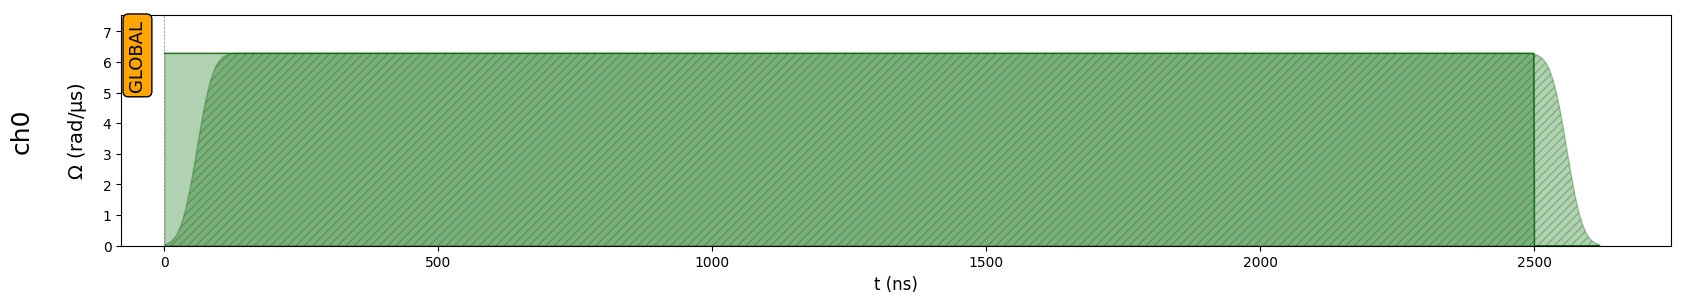

In [3]:
seq = Sequence(reg, AnalogDevice)
seq.declare_channel("ch0", "rydberg_global")
duration = 2500
pulse = Pulse.ConstantPulse(duration, 2 * np.pi, 0.0, 0.0)
seq.add(pulse, "ch0")
seq.draw()

In order to characterize simulation results, we designed a dedicated class, the `SimulationResults` class. It has two child classes, the `CoherentResults` for when the final state can be represented as a state vector or density matrix and `NoisyResults` when it can only be provided as a probability distribution of final states.

In the following, we run a noiseless simulation to obtain a `CoherentResults` object in `clean_res`. This object allows to get useful information on the simulation parameters, the simulation results and more.

In [4]:
sim = QutipEmulator.from_sequence(seq, sampling_rate=0.05)
clean_res = sim.run()

We can for example plot the expectation values of an observable across time

In [5]:
# Define Rydberg state observable
obs = qutip.basis(2, 0).proj()

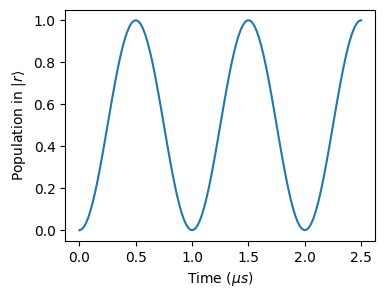

In [6]:
plt.figure(figsize=(4, 3))
plt.plot(clean_res._sim_times, clean_res.expect([obs])[0])
plt.xlabel(r"Time ($\mu s$)")
plt.ylabel(r"Population in $|r\rangle$")
plt.show()

### The SimConfig object

Each simulation has an associated `SimConfig` object, which encapsulates parameters such as noise types, the temperature of the register and so on. You can view it at any time using the `show_config()` method:

In [7]:
sim.show_config()

Options:
----------
Number of runs:        15
Samples per run:       5


When creating a new `SimConfig`, you can choose several parameters such as the number of runs and the number of delivered samples per run through the fields `'runs'` and `'samples_per_run'` respectively. The number of samples per run has no physical interpretation, this is used simply to cut down the calculation time by acquiring more shots without resampling the noise parameters.

### SPAM noise use case

We will use as a toy example the `SPAM` noise and add it to our simulation in order to describe the different objects used for noisy simulations.

To do so, we can create a new `SimConfig` object and assign it to the `config` field of `sim` via the `QutipEmulator.set_config` setter. We pass noise types as a tuple of strings to the `SimConfig` object created.

You can list the different types of noises supported for each basis by calling `Simconfig.supported_noises` as follows:

In [8]:
sim.config.supported_noises

{'ising': {'SPAM',
  'amplitude',
  'dephasing',
  'depolarizing',
  'doppler',
  'eff_noise',
  'leakage',
  'relaxation'},
 'XY': {'SPAM', 'dephasing', 'depolarizing', 'eff_noise', 'leakage'}}

By default, all config classes are in the `ising` mode, allowing a wide range of noises. However, for some applications, we need to operate in the `XY` mode, where only the SPAM noise is available for the moment.

Let's come back to our toy example. We add `"SPAM"` noise to our clean simulation, select 30 different realizations of the state taking each time 5 samples per run:

In [9]:
config_spam = SimConfig(noise=("SPAM"), runs=30, samples_per_run=5)
sim.set_config(config_spam)

The configuration is updated, the current parameters of the SPAM errors should be included:

In [10]:
sim.show_config()

Options:
----------
Number of runs:        30
Samples per run:       5
Noise types:           SPAM
SPAM dictionary:       {'eta': 0.005, 'epsilon': 0.01, 'epsilon_prime': 0.05}


The `SimConfig.spam_dict` is the spam parameters dictionary where `eta` is the probability of a badly prepared state, `epsilon` the false positive probability and `epsilon_prime` the false negative one.

When dealing with a `SimConfig` object with different noise parameters from the config in `QutipEmulator.config`, you can "add" both configurations together, obtaining a single `SimConfig` with all noises from both configurations - on the other hand, the `runs` and `samples_per_run` will always be updated. This adds simulation parameters to noises that weren't available in the former `QutipEmulator.config`. Noises specified in both `SimConfigs` will keep the noise parameters in `QutipEmulator.config`. Try it out with `QutipEmulator.add_config`:

In [11]:
cfg2 = SimConfig(
    noise=("SPAM", "dephasing", "doppler"),
    eta=0.8,
    temperature=1000,
    runs=50,
)
sim.add_config(cfg2)
sim.show_config()

Options:
----------
Number of runs:        50
Samples per run:       5
Noise types:           SPAM, dephasing, doppler
SPAM dictionary:       {'eta': 0.005, 'epsilon': 0.01, 'epsilon_prime': 0.05}
Temperature:           1000.0µK
Dephasing rate: 0.05 (Rydberg), 0.001 (Hyperfine)


We can observe that the `eta` parameter wasn't changed, since both `SimConfig` objects had `'SPAM'` as a noise model already.

We created a noisy simulation using `set_config` and `add_config` methods of the the QutipEmulator class. But it's not the only way, you can directly create a noisy simulation when you create your simulation object.

In [12]:
sim = QutipEmulator.from_sequence(
    seq,
    sampling_rate=0.05,
    config=SimConfig(
        noise=("SPAM", "dephasing", "doppler"),
        temperature=1000,
        runs=50,
    ),
)
sim.show_config()

Options:
----------
Number of runs:        50
Samples per run:       5
Noise types:           SPAM, dephasing, doppler
SPAM dictionary:       {'eta': 0.005, 'epsilon': 0.01, 'epsilon_prime': 0.05}
Temperature:           1000.0µK
Dephasing rate: 0.05 (Rydberg), 0.001 (Hyperfine)


### Setting evaluation times

As a `QutipEmulator` field, `evaluation_times` refers to the times at which you sample during your simulation. You can assign it different types of values:

* A float between 0 and 1: indicating the fraction of the full time array at which you want to sample.
* The string `'Full'` to evaluate every ns or `'Minimal'` to evaluate only at the start and the end.
* A time list: if there are specific periods of times at which you want to sample. Only, make sure the list you use is a subset of the hamiltonian sample time list.

In [13]:
sim.set_evaluation_times(0.5)

In [14]:
noisy_res = sim.run()

We get a `NoisyResults` object from our noisy simulation. This object represents the final result as a probability distribution over the sampled bitstrings, rather than a quantum state `QObj` in the `CleanResults` case.

### Plotting noisy and clean results

The new `res` instance has similar methods to the usual `SimResults` object. For example, we can calculate expectation values. 

Below, the comparison between the clean and noise simulations.

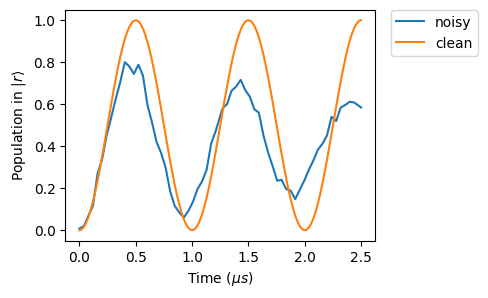

In [15]:
plt.figure(figsize=(4, 3))
plt.plot(noisy_res._sim_times, noisy_res.expect([obs])[0], label="noisy")
plt.plot(clean_res._sim_times, clean_res.expect([obs])[0], label="clean")
plt.xlabel(r"Time ($\mu s$)")
plt.ylabel(r"Population in $|r\rangle$")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.show()

You can also use the `SimResults.plot(obs)` method to plot expectation values of a given observable. Here we compute the `sigma_z` local operator expectation values. Error bars are activated by default for noise simulations but if you don't want them you can set to False the field `error_bars`.

Be wary that computing the expectation value of non-diagonal operators will raise an error, as `NoisyResults` bitstrings are already projected on the $Z$ basis.

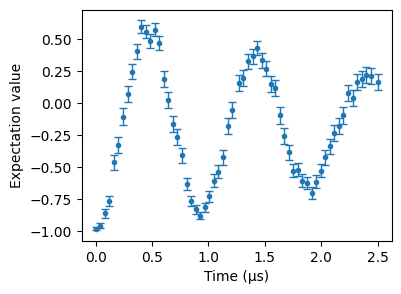

In [16]:
obs = qutip.sigmaz()
plt.figure(figsize=(4, 3))
noisy_res.plot(obs, fmt=".")

Now you have the basic knowledge to tackle noise simulations. In the following tutorials, we will see in more detail simulations with [SPAM errors](spam.nblink), [laser noise](laser_noise.nblink) and [effective noise channels](effective_noise.nblink). Enjoy!